In [79]:
# chargement des modules nécessaires 
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler


# Introduction

In [80]:
# Chargement du CSV
df = pd.read_csv('creditcard.csv')

Les algorithmes que nous allons utiliser adoptent par convenstion le label -1 pour les outliers et 1 pour les inliers

In [81]:
# Mofification labels 1 de la var Class en -1 et 1
df['Class'].replace({1: -1}, inplace=True)
df['Class'].replace({0: 1}, inplace=True)

C:\Users\sarah\AppData\Local\Temp\ipykernel_22192\1277860689.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Class'].replace({1: -1}, inplace=True)
C:\Users\sarah\AppData\Local\Temp\ipykernel_22192\1277860689.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

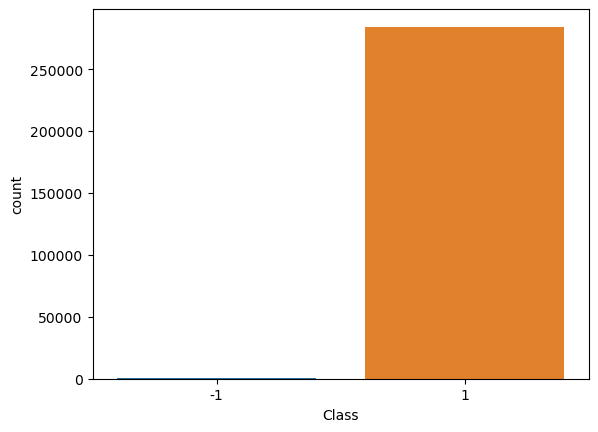

In [82]:

sns.countplot(data=df, x='Class');


La taille du jeu de données est grand, nous allons prendre qu'une partie des données.

(20000, 31)
(492, 31)
(20492, 31)


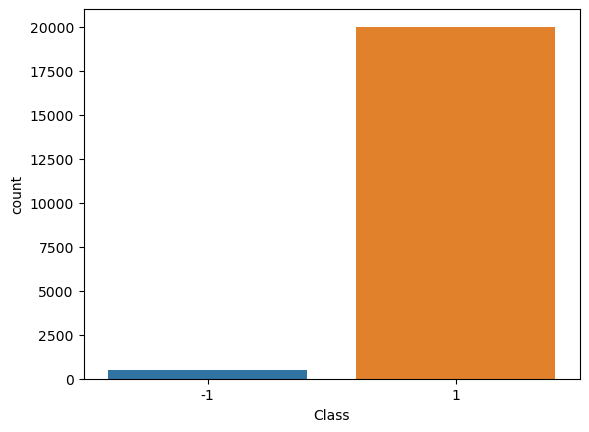

In [83]:

# Sélection données où la classe est égale à 1 (inliers)
df_inliers = df[df['Class'] == 1]

# premières 20000 lignes
df_inliers = df_inliers[:20000]

# Sélection données où la classe est égale à -1 (outliers)
df_outliers = df[df['Class'] == -1]

# Concatenation données sélectionnées
df = pd.concat([df_inliers, df_outliers])

# Définition de la cible
target = df['Class']

# Affichage formes des dataframes
print(df_inliers.shape)
print(df_outliers.shape)
print(df.shape)

# Affichage countplot de la cible
sns.countplot(x='Class', data=df);

In [84]:
# Stockage proportion outliers 
frac = df[df['Class']==-1]['Class'].count()/df['Class'].count()
frac


0.024009369510052704

Nous constatons un déséquilibre important entre les classes de notre jeu de données. 

Pour évaluer nos algorithmes, nous allons le diviser en un ensemble de test. 

La fonction train_test_split sera utilisée pour maintenir la proportion des classes dans les ensembles de données créés.

Les méthodes que l’on va utiliser sont des méthodes d’apprentissage non-supervisé, les labels de y_train ne seront pas utilisées dans les algorithmes.

In [85]:
X_train, X_test, y_train, y_test= train_test_split(df, target, test_size=0.2)
X_train = X_train.drop('Class', axis = 1)
X_test = X_test.drop('Class', axis = 1)

La variable time n'est pas pertinente, nous allons l'enlever. 

In [87]:
X_train_notime = X_train.drop('Time', axis=1)
X_test_notime = X_test.drop('Time', axis=1)

# Isolation Forest
Isolation Forest, basée sur des arbres de décision, identifie les outliers en sélectionnant aléatoirement des variables et en les divisant en sous-ensembles jusqu'à l'isolation des données, répétée de manière récursive.

In [88]:
# Instanciation d'un obj IsolationForest
isof = IsolationForest(contamination=0.03, n_estimators=100, n_jobs=-1)

In [89]:
# Entrainement du modèle
isof.fit(X_train_notime)

# Prédiction sur test
y_pred = isof.predict(X_test_notime)

# Affichage matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,-1,1
Classes réelles,,
-1,73,38
1,64,3924


In [91]:
# Rapport de classification 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.53      0.66      0.59       111
           1       0.99      0.98      0.99      3988

    accuracy                           0.98      4099
   macro avg       0.76      0.82      0.79      4099
weighted avg       0.98      0.98      0.98      4099



L'algorithme montre une capacité intrinsèque à obtenir des performances satisfaisantes dans des problématiques complexes de détection de fraude. 

Bien que le f1-score soit couramment utilisé pour évaluer les modèles en cas de déséquilibre de classe, une attention particulière peut être portée à l'optimisation de métriques spécifiques telles que le rappel. 

Nous chercherons à améliorer le rappel en ajustant le taux de contamination

In [92]:
# découpe manuel jeu de données de validation croisée dans échantillon apprentissage
skf = StratifiedKFold(n_splits=3) 
folds = list(skf.split(X_train_notime, y_train))

# Initialisation du modèle Isolation Forest
forest = IsolationForest()

# Dans la situation où on ne connait pas à priori le paramètre de contamination,
# on ajoutera la contamination dans la grille de recherche
resc = make_scorer(recall_score, pos_label=-1)

# Définition des paramètres pour la grille de recherche
params = {'contamination': np.linspace(0.01, 0.05, 10), 'n_estimators': [100, 200, 300]}

# Recherche des meilleurs paramètres avec validation croisée
search = GridSearchCV(estimator=forest, param_grid=params, scoring=resc, cv=folds, n_jobs=-1)
search.fit(X_train_notime, y_train)

# Obtention du meilleur modèle
optimal_forest = search.best_estimator_

# Prédiction sur les données de test
y_pred = optimal_forest.predict(X_test_notime)

# Affichage de la matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])



Classes prédites,-1,1
Classes réelles,,
-1,87,24
1,138,3850


In [93]:
# Affichage du rapport de classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.39      0.78      0.52       111
           1       0.99      0.97      0.98      3988

    accuracy                           0.96      4099
   macro avg       0.69      0.87      0.75      4099
weighted avg       0.98      0.96      0.97      4099



Le modèle affiche un meilleur score de rappel, démontrant ainsi une amélioration de sa capacité à détecter les données anormales.

 En fin de compte, l'algorithme Isolation Forest produit des résultats satisfaisants, même dans des situations de problématique complexe.

# One class SVM

La détection d'outliers en machine learning peut être supervisée, semi-supervisée ou non supervisée. 

L'One-class SVM est une variante du SVM classique adaptée à la détection de nouveautés.

Elle repose sur l'hypothèse que les données d'entraînement sont exemptes d'outliers, et isole ces données par rapport à l'origine à l'aide d'un hyperplan. 

Cette méthode ne nécessite pas de données étiquetées pour l'entraînement, mais il est essentiel de s'assurer que les données ne sont pas contaminées par des outliers. 

Ainsi, une étape préliminaire consiste à ne conserver que les données non polluées par des anomalies.

In [94]:
# Selection uniquement labels = 1
y_inliers = y_train[y_train.values==1]

# liste d'index pour pouvoir récupérer les variables explicatives de ces index
liste = list(y_inliers.index.values)

# récupèration variables explicatives dans un nouveau DataFrame
X_train_inliers = X_train.loc[liste]


On cherche à séparer les données du point origine (de coordonnées 0.)

In [95]:
# Création objet Scaler
scaling = MinMaxScaler(feature_range=(-1, 1)).fit(X_train_inliers)

# Entrainement scaler à partir du dataset utilisé dans la phase d'apprentissage
X_train_inliers = scaling.transform(X_train_inliers)

# transformation X_test avec les informations du DataFrame d'apprentissage
X_test = scaling.transform(X_test)

In [96]:
# Définition objet OneClassSVM
clf_osvm = svm.OneClassSVM(kernel='rbf', nu=0.005, gamma='scale')

# Entrainement du modèle
clf_osvm.fit(X_train_inliers)

OneClassSVM(nu=0.005)

In [97]:
# Prédiction à partir des variables explicatives de l'échantillon de test
y_pred = clf_osvm.predict(X_test)

# Affichage des résultats sous la forme d'une matrice de confusion
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])


Classes prédites,-1,1
Classes réelles,,
-1,102,9
1,16,3972


In [98]:
# Affichage rapport de prediction
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.92      0.89       111
           1       1.00      1.00      1.00      3988

    accuracy                           0.99      4099
   macro avg       0.93      0.96      0.94      4099
weighted avg       0.99      0.99      0.99      4099



Les resultat sont très satisfaisant, il est possible d'optimiser ce modèle en testant plusieurs hyperparamètre à l'aide d'une grille de recherche.

# conlusion

- La problématique de détection d'anomalie est considérée lorsque le jeu de données contient des labels spécifiques à de très faibles proportions.
- Plusieurs algorithmes et techniques permettent d'aborder cette problématique.
- Les différents modèles peuvent facilement être implémentés et entraînés à l'aide de scikit-learn.
- Avoir à priori des données labélisées permet de valider l'efficacité d'un modèle.